In [1]:
import networkx as nx
import itertools as it
from scipy.optimize import minimize
def pairs(li):
    return [(li[i],li[(i+1)%len(li)]) for i in range(len(li))]
import matplotlib.pyplot as plt


In [2]:

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
# class for a non-bipartite quadrangulation-graphs
class NBQP:
    def __init__(self, ingraph, rotation,coloring=None):
        self.graph=ingraph
        self.rotation = rotation
        self.nnum=self.graph.number_of_nodes()
        self.quads=self.compute_quads()
        self.coloring=coloring
        self.prevdata=None
    # compute the quads from the rotation system
    def compute_quads(self):
     #   print("computing quads",self.rotation)
        quadslist=set()
        for v,neig in self.rotation.items():
           # print(v,neig)
            for w1,w2 in pairs(neig):
                v2ind=(self.rotation[w1].index(v)+1)%len(self.rotation[w1])
                v2=self.rotation[w1][v2ind]
                #start with min and newquad[1] is followed by newquad[3] in the rotation of newquad[0] 
                newquad=[v,w1,v2,w2]
                
                start=np.argmin(newquad)
                if start%2==0:
                    ordered=tuple(newquad[start:]+newquad[:start])
                    #print('haho',v,w1,w2,self.rotation[w1],ordered)
                    quadslist.add(ordered)
        return quadslist
    # get a list of all diagonals in the quadrangulation
    def diagonal_list(self):
        return [(quad[0],quad[2]) for quad in self.quads]+[(quad[1],quad[3]) for quad in self.quads]
    # get the diagonal graph
    def diag_graph(self):
        G=nx.Graph()
        G.add_edges_from(self.diagonal_list())
        return G
    
    def __repr__(self):
        return "NBQP graph:%s rotation:%s quads:%s cols:%s" % (list(self.graph.edges), self.rotation, self.quads,self.coloring)
    
    def __str__(self):
        return "NBQP graph:%s rotation:%s quads:%s cols:%s" % (list(self.graph.edges), self.rotation, self.quads,self.coloring)
    

In [ ]:
# base case K4

k4=nx.Graph()
k4.add_edges_from([(0, 1), (0, 2),(0,3), (1, 2), (1, 3),(2, 3)])
q4rotation={0:(1,3,2),1:(0,2,3),2:(0,3,1),3:(0,1,2)}
k4coloring={0:0,1:1,2:2,3:3}
q4=NBQP(k4,q4rotation,k4coloring)
print(q4)


NBQP graph:[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)] rotation:{0: (1, 3, 2), 1: (0, 2, 3), 2: (0, 3, 1), 3: (0, 1, 2)} quads:{(0, 1, 2, 3), (0, 2, 3, 1), (0, 3, 1, 2)} cols:{0: 0, 1: 1, 2: 2, 3: 3}


In [11]:
# the diagonal graph of K4 is also K4
q4.diagonal_list()

[(0, 2), (0, 3), (0, 1), (1, 3), (2, 1), (3, 2)]

In [12]:

# splilt a graph at a vertex a along the neighbors b1 and b2
def split(q,a,b1,b2):
    #q is an nbqp, we split a at b1b2
    newgraph=q.graph.copy()
    rotation=q.rotation
    rota=rotation[a]
    i1=rota.index(b1)
    i2=rota.index(b2)
    #legyen b1 az ami az a rotationjeben eloszor jon, listás értelemben
    if i2==min(i1,i2):
        b1,b2=b2,b1
    i1,i2=min(i1,i2),max(i1,i2)
    
    
    rotb1=rotation[b1]
    rotb2=rotation[b2]
    
    
    n1=rota[i1+1:i2]
    n2=rota[i2+1:]+rota[:i1]
    
    #print("n1n2",n1,n2)
    newrot=rotation.copy()
    
    del newrot[a]
    #print('a',newrot)
    if 0 not in newrot.keys():
        newind1=0
    else:
        newind1=min(i+1 for i in newrot.keys() if i+1 not in newrot.keys() )
    newrot[newind1]=()
    
    newind2=min(i+1 for i in newrot.keys() if i+1 not in newrot.keys() )
  #  print('new indices:',newind1,newind2)
    #fixgraph
    newgraph.remove_node(a)
    newgraph.add_edges_from([(newind1,x) for x in n1])
    newgraph.add_edges_from([(newind2,x) for x in n2])
    newgraph.add_edges_from([(newind1,b1),(newind1,b2)])
    newgraph.add_edges_from([(newind2,b1),(newind2,b2)])

    
    
    newrot[newind1]=tuple([b1]+list(n1)+[b2])
    newrot[newind2]=tuple([b2]+list(n2)+[b1])
    ainb1=rotb1.index(a)
    ainb2=rotb2.index(a)
    newrotb1=rotb1[:ainb1]+(newind2,newind1)+rotb1[ainb1+1:]
    newrotb2=rotb2[:ainb2]+(newind1,newind2)+rotb2[ainb2+1:]
    newrot[b1]=tuple(newrotb1)
    newrot[b2]=tuple(newrotb2)
#[4 if x==1 else x for x in a]
    
    #fix n1n2 rotation...
    for v in n1:
        newrot[v]=tuple([newind1 if x==a else x for x in rotation[v]])
    for v in n2:
        newrot[v]=tuple([newind2 if x==a else x for x in rotation[v]])
    newcoloring=None
    if q.coloring:
        newcoloring={}
        for v in newgraph.nodes:
            if v==newind1 or v==newind2:
                newcoloring[v]=q.coloring[a]
            else:
                newcoloring[v]=q.coloring[v]
    
    return NBQP(newgraph,newrot,newcoloring)

print(split(q4,0,1,3))

NBQP graph:[(1, 2), (1, 3), (1, 0), (1, 4), (2, 3), (2, 4), (3, 0), (3, 4)] rotation:{1: (4, 0, 2, 3), 2: (4, 3, 1), 3: (0, 4, 1, 2), 0: (1, 3), 4: (3, 2, 1)} quads:{(0, 3, 4, 1), (1, 2, 4, 3), (0, 1, 2, 3), (1, 3, 2, 4)} cols:{1: 1, 2: 2, 3: 3, 4: 0, 0: 0}


In [13]:
q5=split(q4,0,1,3)

q6list=[]
print('q5',q5)
print(split(q5,1,0,3))

q5 NBQP graph:[(1, 2), (1, 3), (1, 0), (1, 4), (2, 3), (2, 4), (3, 0), (3, 4)] rotation:{1: (4, 0, 2, 3), 2: (4, 3, 1), 3: (0, 4, 1, 2), 0: (1, 3), 4: (3, 2, 1)} quads:{(0, 3, 4, 1), (1, 2, 4, 3), (0, 1, 2, 3), (1, 3, 2, 4)} cols:{1: 1, 2: 2, 3: 3, 4: 0, 0: 0}
NBQP graph:[(2, 3), (2, 4), (2, 1), (3, 0), (3, 4), (3, 1), (3, 5), (4, 5), (0, 1), (0, 5)] rotation:{2: (4, 3, 1), 3: (0, 4, 1, 5, 2), 0: (5, 1, 3), 4: (3, 2, 5), 1: (0, 2, 3), 5: (3, 4, 0)} quads:{(2, 4, 5, 3), (0, 5, 3, 1), (1, 2, 4, 3), (0, 1, 2, 3), (0, 3, 4, 5)} cols:{2: 2, 3: 3, 4: 0, 0: 0, 1: 1, 5: 1}


In [ ]:
# we store the graphs in a dictionary by number of vertices, only one of size 4 to start with
collection={}
collection[4]={'nbqp_list':[q4],'graph_list':[q4.graph]}

In [15]:
collection[5]={'nbqp_list':[],'graph_list':[]}
for nbqp in collection[4]['nbqp_list']:
    g=nbqp.graph
    rot=nbqp.rotation
    for v in list(g.nodes):
        for w1,w2 in it.combinations(rot[v],2):
            newnbqp=split(nbqp,v,w1,w2)
            newnbqp.prevdata=(nbqp,v,w1,w2)
            found=False
            for gr in collection[5]['graph_list']:
                if nx.is_isomorphic(newnbqp.graph, gr):
                    found=True
                    break
            if not found:
                
                collection[5]['nbqp_list'].append(newnbqp)
                collection[5]['graph_list'].append(newnbqp.graph)
                
                
            
    

In [ ]:
#calculates next level
for j in [6,7,8,9,10]:
    size=j
    collection[size]={'nbqp_list':[],'graph_list':[]}
    for nbqp in collection[size-1]['nbqp_list']:
        g=nbqp.graph
        rot=nbqp.rotation
        for v in list(g.nodes):
            for w1,w2 in it.combinations(rot[v],2):
                newnbqp=split(nbqp,v,w1,w2)
                newnbqp.prevdata=(nbqp,v,w1,w2)
                found=False
                for gr in collection[size]['graph_list']:
                    if nx.is_isomorphic(newnbqp.graph, gr):
                        found=True
                        break
                if not found:
                    collection[size]['nbqp_list'].append(newnbqp)
                    collection[size]['graph_list'].append(newnbqp.graph)


In [18]:
# calculates next level efficiently
lastlevel=11
for j in range(6,lastlevel+1):
    size = j
    collection[size] = {'nbqp_list': [], 'graph_list': []}
    graph_hashes = set()
    for nbqp in collection[size - 1]['nbqp_list']:
        g = nbqp.graph
        rot = nbqp.rotation
        for v in list(g.nodes):
            for w1, w2 in it.combinations(rot[v], 2):
                newnbqp = split(nbqp, v, w1, w2)
                newnbqp.prevdata = (nbqp, v, w1, w2)
                gr = newnbqp.graph
                gr_hash = nx.weisfeiler_lehman_graph_hash(gr)
                if gr_hash not in graph_hashes:
                    collection[size]['nbqp_list'].append(newnbqp)
                    collection[size]['graph_list'].append(gr)
                    graph_hashes.add(gr_hash)


In [19]:
for i in [4,5,6,7,8,9,10,11]:
    print(i,len(collection[i]['graph_list']))

4 1
5 1
6 4
7 14
8 58
9 266
10 1360
11 7232


In [21]:
from pysat.formula import IDPool
from pysat.solvers import Solver

def check_coloring_orientation(graph, k):
    """
    graph: dict {u: [neighbors]} adjacency list
    k: number of colors to try
    returns: True if such a coloring+orientation exists, else False
    """
    vpool = IDPool()

    def col(v, c):
        return vpool.id(("col", v, c))

    def orient(u, v):
        return vpool.id(("orient", u, v))  # meaning edge u->v

    with Solver(name="glucose3") as solver:
        # 1. each vertex has exactly one color
        for v in graph:
            solver.add_clause([col(v, c) for c in range(k)])
            for c1 in range(k):
                for c2 in range(c1+1, k):
                    solver.add_clause([-col(v, c1), -col(v, c2)])

        # 2. adjacent vertices different colors
        for u in graph:
            for v in graph[u]:
                if u < v:  # avoid double
                    for c in range(k):
                        solver.add_clause([-col(u, c), -col(v, c)])

        # 3. edge orientation: exactly one direction
        for u in graph:
            for v in graph[u]:
                if u < v:
                    solver.add_clause([orient(u, v), orient(v, u)])
                    solver.add_clause([-orient(u, v), -orient(v, u)])

        # 4. outgoing neighbors of each vertex must share same color
        for u in graph:
            for v in graph[u]:
                for w in graph[u]:
                    if v < w:  # avoid double
                        for c1 in range(k):
                            for c2 in range(k):
                                if c1 != c2:
                                    # if u->v and u->w then color(v)=color(w)
                                    solver.add_clause([-orient(u, v), -orient(u, w), -col(v, c1), -col(w, c2)])

        sat = solver.solve()
        if not sat:
            return None, None
        model = solver.get_model()
        coloring = {}
        orientation = {}
        for v in graph:
            for c in range(k):
                if col(v, c) in model and model[model.index(col(v, c))] > 0:
                    coloring[v] = c
        for u in graph:
            for v in graph[u]:
                if orient(u, v) in model and model[model.index(orient(u, v))] > 0:
                    orientation[(u, v)] = True
                elif orient(v, u) in model and model[model.index(orient(v, u))] > 0:
                    orientation[(u, v)] = False
        return coloring, orientation
        return sat


Graph 45 of size 9 is colorable with 6 colors


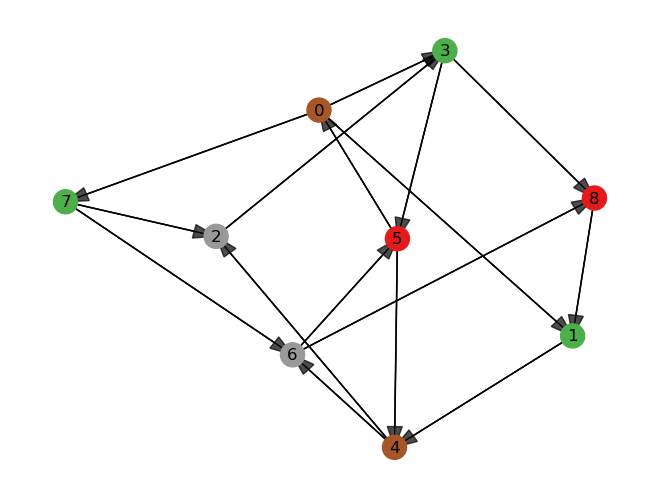

Graph 49 of size 10 is colorable with 6 colors


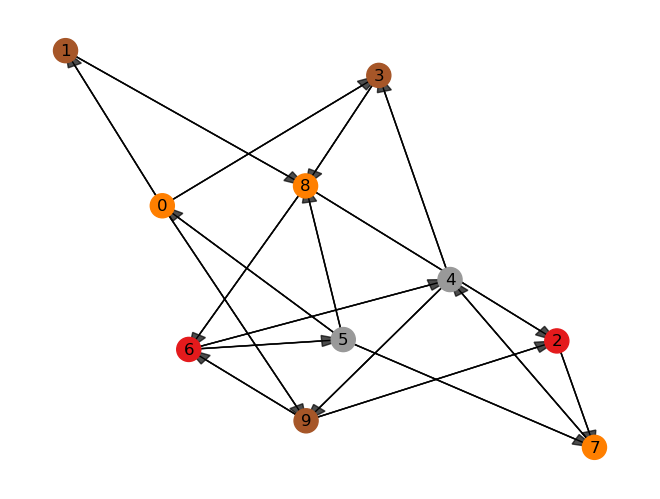

Graph 56 of size 10 is colorable with 6 colors


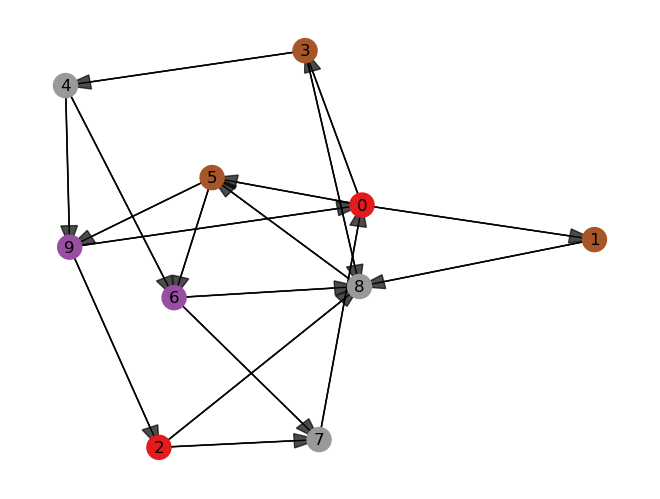

Graph 407 of size 10 is colorable with 6 colors


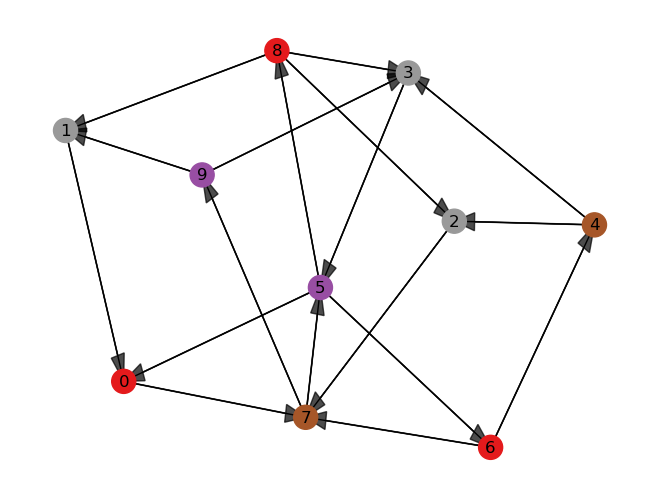

Graph 463 of size 10 is colorable with 6 colors


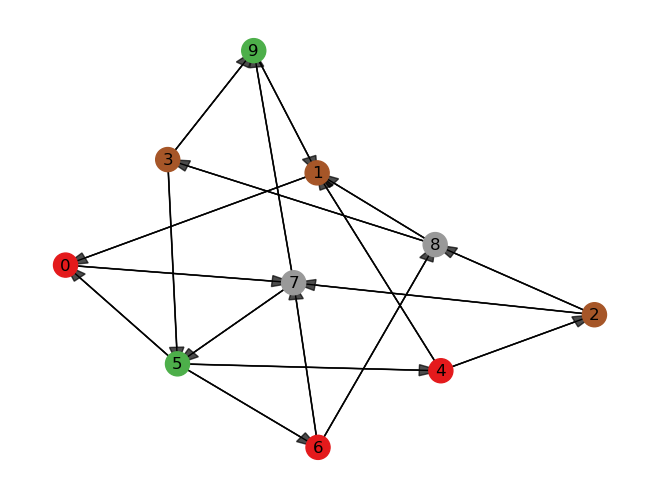

Graph 466 of size 10 is colorable with 6 colors


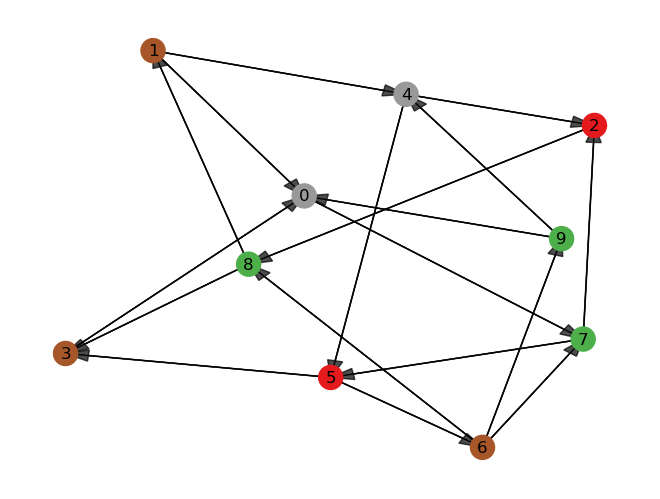

Graph 496 of size 10 is colorable with 6 colors


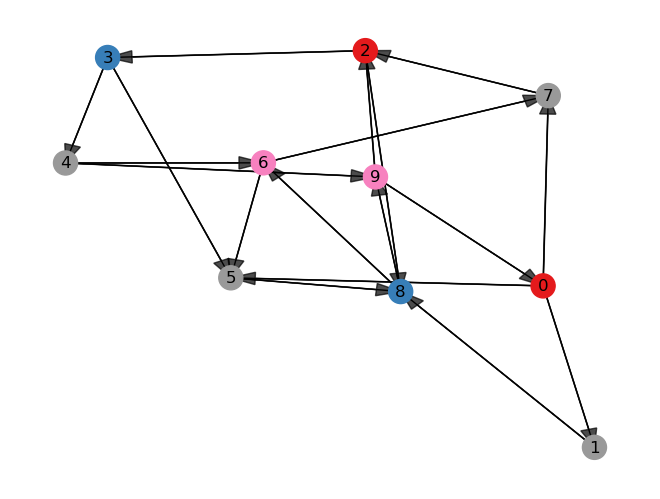

In [22]:
# Try to color and orient the graphs with 6 colors
colnum=6
for i in [4,5,6,7,8,9,10]:
    for g in range(len(collection[i]['graph_list'])):
        gr=collection[i]['graph_list'][g]
        adj={u:list(gr.neighbors(u)) for u in gr.nodes}
        coloring, orientation = check_coloring_orientation(adj, colnum)
        if coloring and orientation:
            print("Graph", g, "of size", i, "is colorable with", colnum, "colors")
            # Draw the graph with colors and orientations
            pos = nx.spring_layout(gr)
            node_colors = [coloring[v] for v in gr.nodes]
            nx.draw(gr, pos, with_labels=True, node_color=node_colors, cmap=plt.cm.Set1)
            # Draw oriented edges
            for (u, v) in gr.edges:
                if orientation.get((u, v), False):
                    plt.arrow(pos[u][0], pos[u][1], pos[v][0] - pos[u][0], pos[v][1] - pos[u][1],
                              length_includes_head=True, head_width=0.05, color='black', alpha=0.7)
                elif orientation.get((v, u), False):
                    plt.arrow(pos[v][0], pos[v][1], pos[u][0] - pos[v][0], pos[u][1] - pos[v][1],
                              length_includes_head=True, head_width=0.05, color='black', alpha=0.7)
            plt.show()
            
        else:
            pass
           # print("Graph",g,"of size",i,"is NOT colorable with",colnum,"colors")

In [39]:
2

2